# Viewing MAGIC/LST simulated events
---

&copy; Ievgen Vovk, Lab Saha, Moritz Hütten, David Green, for the LST-I bootcamp 11/2018

---

In [1]:
import pandas as pd

import traitlets

import ctapipe

from ctapipe.io import EventSourceFactory, event_source, HDF5TableWriter
from ctapipe.instrument import CameraGeometry
from ctapipe.instrument import TelescopeDescription
from ctapipe.instrument import OpticsDescription

from ctapipe.calib import CameraCalibrator
from ctapipe.visualization import CameraDisplay
from ctapipe.image import tailcuts_clean, hillas_parameters
from ctapipe.image.timing_parameters import timing_parameters

from astropy import units as u

from matplotlib import pyplot

## 1. MAGIC camera geometry and optics

The telescope optics information is read from the information stored in `ctapipe-extra`. We can read specification of the MAGIC optical system without loading the data: 

In [2]:
magic_optics = OpticsDescription.from_name('MAGIC')
magic_camera = CameraGeometry.from_name('MAGICCam')
magic_tels = TelescopeDescription(optics=magic_optics, camera=magic_camera)

print("MAGIC:")
print("  Mirror area: {:.1f}".format(magic_tels.optics.mirror_area))
print("  Mirror tiles count: {}".format(magic_tels.optics.num_mirror_tiles))
print("  Mirror focal length: {}".format(magic_tels.optics.equivalent_focal_length))

IndexError: index 0 is out of bounds for axis 0 with size 0

In [31]:
lst_optics = OpticsDescription.from_name('LST')
lst_camera = CameraGeometry.from_name('LSTCam')
lst_tels = TelescopeDescription(optics=lst_optics, camera=lst_camera)

print("LST:")
print("  Mirror area: {:.1f}".format(lst_tels.optics.mirror_area))
print("  Mirror tiles count: {}".format(lst_tels.optics.num_mirror_tiles))
print("  Mirror focal length: {}".format(lst_tels.optics.equivalent_focal_length))

LST:
  Mirror area: 386.7 m2
  Mirror tiles count: 198
  Mirror focal length: 28.0 m


If in doubt as to how the camera in need is called, just ask the base class for the known ones:

In [32]:
print('Known cameras are:', CameraGeometry.get_known_camera_names())

Known cameras are: ['ASTRICam', 'NectarCam', 'NectarCam-001', 'HESS-I', 'VERITAS', 'FlashCam', 'CHEC', 'LSTCam-001', 'MAGICCam', 'LSTCam', 'SCTCam', 'Whipple109', 'Whipple151', 'Whipple490', 'HESS-II', 'MAGICCamIevgen', 'FACT', 'MAGICCamMars', 'Whipple331', 'DigiCam']


**Note:** there are at the moment two MAGIC camera geometries: `MAGICCam` and `MAGICCamMars`. The geometries are stored in the files `MAGICCam.camgeom.fits.gz` and `MAGICCamMars.camgeom.fits.gz` within `ctapipe_extra`. `MAGICCamMars` corresponds to the coordinate transformation $x \rightarrow -y$, $y \rightarrow x$ (mirroring the image at the  $x = -y$ axis) w.r.t. `MAGICCam`. The geometry `MAGICCamMars` corresponds to the event display of the MAGIC analysos software *MARS*, whereas *ctapipe* uses the H.E.S.S. convention.


<sub>It seems that all meta information stored in the `ctapipe_extra/ctapipe-resources/*.camgeom.fits` geometriy definition files (pixel rotation, camera rotation, name of the camera) overrides the information written in `_CAMERA_GEOMETRY_TABLE` in `ctapipe/instrument/camera.py`. It seems that the `_CAMERA_GEOMETRY_TABLE` information is only used when no `*.camgeom.fits` files exist.</sub>

## 2. Loading the data

We will load the simulation containing both MAGIC 1/2 and LST 1/2/3/4 triggered events.

Note: ctapipe will determine the correct EventSourceFactory automatically given the specified input file.

Also note: wild cards are not supported at the moment.

In [33]:
input_data_file = "../data/gamma_20deg_174.681deg_run9___cta-prod4-lapalma-2158m--baseline_with-MAGIC_cone1.5.simtel.gz"
event_factory = EventSourceFactory.produce(input_url=input_data_file)
event_generator = event_factory._generator()

## 3. Reading events

After the data are loaded it's time to read event and retrieve the basic info about them.

Events can be triggered by any of the telescopes. We will look for an event seen by all of them.

In [34]:
for i in range(0, 5):
    event = next(event_generator)

    tels_with_data = event.r1.tels_with_data
    print("Triggered telescopes: {}".format(tels_with_data))

Triggered telescopes: {4}
Triggered telescopes: {1, 3, 4, 6}
Triggered telescopes: {5}
Triggered telescopes: {3, 4, 5, 6}
Triggered telescopes: {1, 2, 3, 4, 5, 6}


What telescopes were these?

In [35]:
for tel_id in tels_with_data:
    print('Telescope {} has a camera called "{}"'.format(tel_id, event.inst.subarray.tel[tel_id].camera.cam_id))

Telescope 1 has a camera called "MAGICCam"
Telescope 2 has a camera called "MAGICCam"
Telescope 3 has a camera called "LSTCam"
Telescope 4 has a camera called "LSTCam"
Telescope 5 has a camera called "LSTCam"
Telescope 6 has a camera called "LSTCam"


## 4. MC images: how the event should have (could have) looked like.

This is how this event should look like in the perfect world.

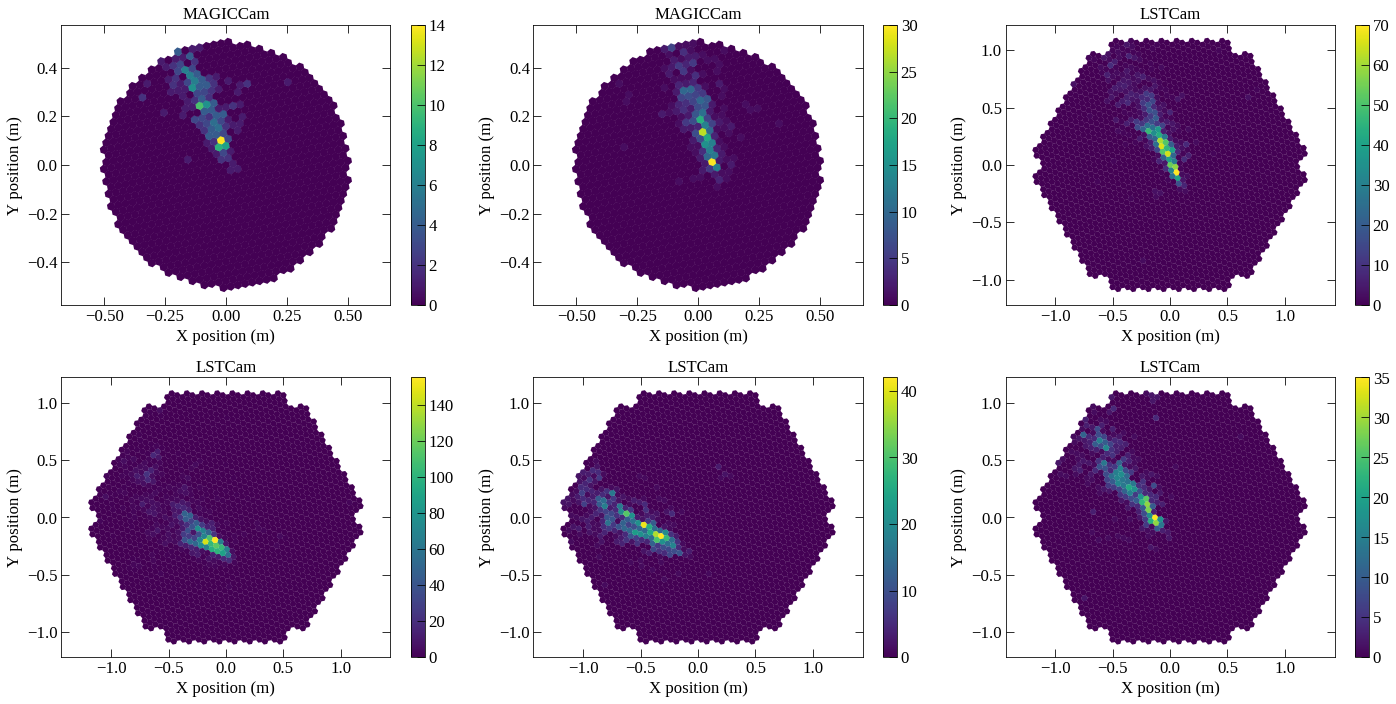

In [36]:
pyplot.figure(figsize=(20, 10))
pyplot.style.use('presentation')

for tel_id in tels_with_data:
    pyplot.subplot(2, 3, tel_id)
    if tel_id <= 2:
        # First two telescopes are MAGICs
        disp = CameraDisplay(magic_camera, event.mc['tel'][tel_id]['photo_electron_image'])
    else:
        # The next 4 are LSTs
        disp = CameraDisplay(lst_camera, event.mc['tel'][tel_id]['photo_electron_image'])
    disp.add_colorbar()
    
pyplot.tight_layout()

## 5. Real images: how the event actually looks like

**Note**: certain things in *ctapipe* are set up in a centralized way via *traitlets*.

To control their settings, one needs to create a "config" object and populate  its fields.

Traitlets configuration is accessed like a dictionary: first key - the class of interest, second - the value to adjust.

Here is an example of how to set up the calibrator instance via the traitlets:

In [37]:
config = traitlets.config.Config()
config['NeighbourPeakIntegrator']['window_width'] = 6
config['NeighbourPeakIntegrator']['window_shift'] = 2
config['CameraDL1Calibrator']['clip_amplitude'] = 8000

calibrator = CameraCalibrator(r1_product="HESSIOR1Calibrator", 
                              extractor_product="NeighbourPeakIntegrator", config=config)
calibrator.calibrate(event)

**Those working with CTA/MARS note:** ctapipe and Chimp use different conversions factors!

Here we convert the event image to the "Chimp scale" for demonstration purposes.

In [38]:
cpipe_to_chimp_scale = 0.92 / 1.05

In [39]:
tel_id = 1
event_image = event.dl1.tel[tel_id].image[1]
data_image_max = event_image.max() * cpipe_to_chimp_scale
mc_image_max = event.mc['tel'][tel_id]['photo_electron_image'].max()
print(f"Data image max: {data_image_max:.2f}")
print(f"MC image max: {mc_image_max:.2f}")
print(f"Image sum: {event_image.sum():.2f}")

Data image max: 13.34
MC image max: 14.00
Image sum: 196.01


Finally, let's plot the calibrated event images.

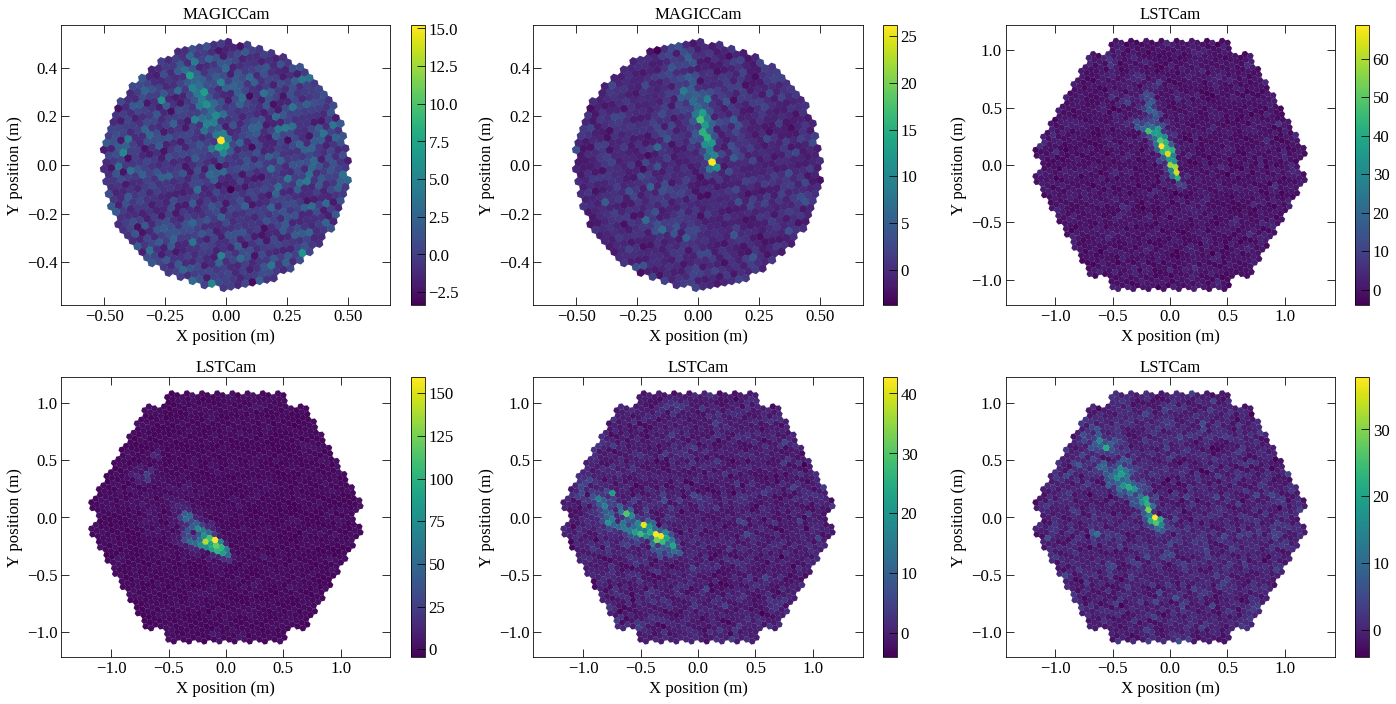

In [40]:
pyplot.figure(figsize=(20, 10))
pyplot.style.use('presentation')

for tel_id in tels_with_data:
    pyplot.subplot(2, 3, tel_id)
    if tel_id <= 2:
        # First two telescopes are MAGICs
        disp = CameraDisplay(magic_camera, event.dl1.tel[tel_id].image[1])
    else:
        # The next 4 are LSTs
        disp = CameraDisplay(lst_camera, event.dl1.tel[tel_id].image[1])
    disp.add_colorbar()
    
pyplot.tight_layout()

## 6. Cleaning the image(s)
Will use here the algorithm equivalent to the MAGIC "absolute image cleaning".

Note: cleaning thresholds are by no means optimal here.

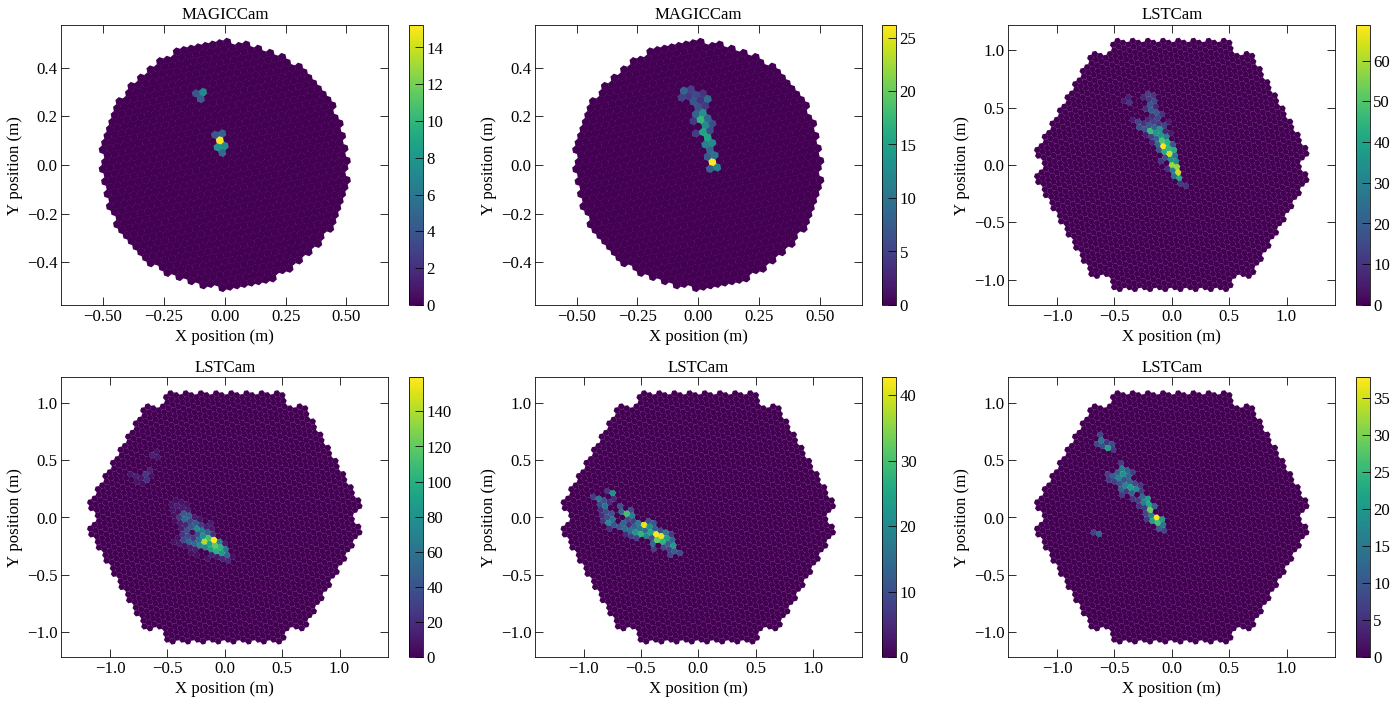

In [41]:
pyplot.figure(figsize=(20, 10))
pyplot.style.use('presentation')

for tel_id in tels_with_data:
    pyplot.subplot(2, 3, tel_id)
    
    event_image = event.dl1.tel[tel_id].image[1]
    
    if tel_id <= 2:
        # -> Here comes the cleaning
        mask = tailcuts_clean(magic_camera, event_image, picture_thresh=6, boundary_thresh=4)
        event_image_cleaned = event_image.copy()
        event_image_cleaned[~mask] = 0
        
        disp = CameraDisplay(magic_camera, event_image_cleaned)
        
    else:
        # Will use somewhat higher cleaning levels for LSTs
        mask = tailcuts_clean(lst_camera, event_image, picture_thresh=10, boundary_thresh=5)
        event_image_cleaned = event_image.copy()
        event_image_cleaned[~mask] = 0
        
        disp = CameraDisplay(lst_camera, event_image_cleaned)
    disp.add_colorbar()
    
pyplot.tight_layout()

## 7. Hillas parameters estimation

It's time to compute the Hillas parameters. For clarity let's overlay them on the cleaned images.

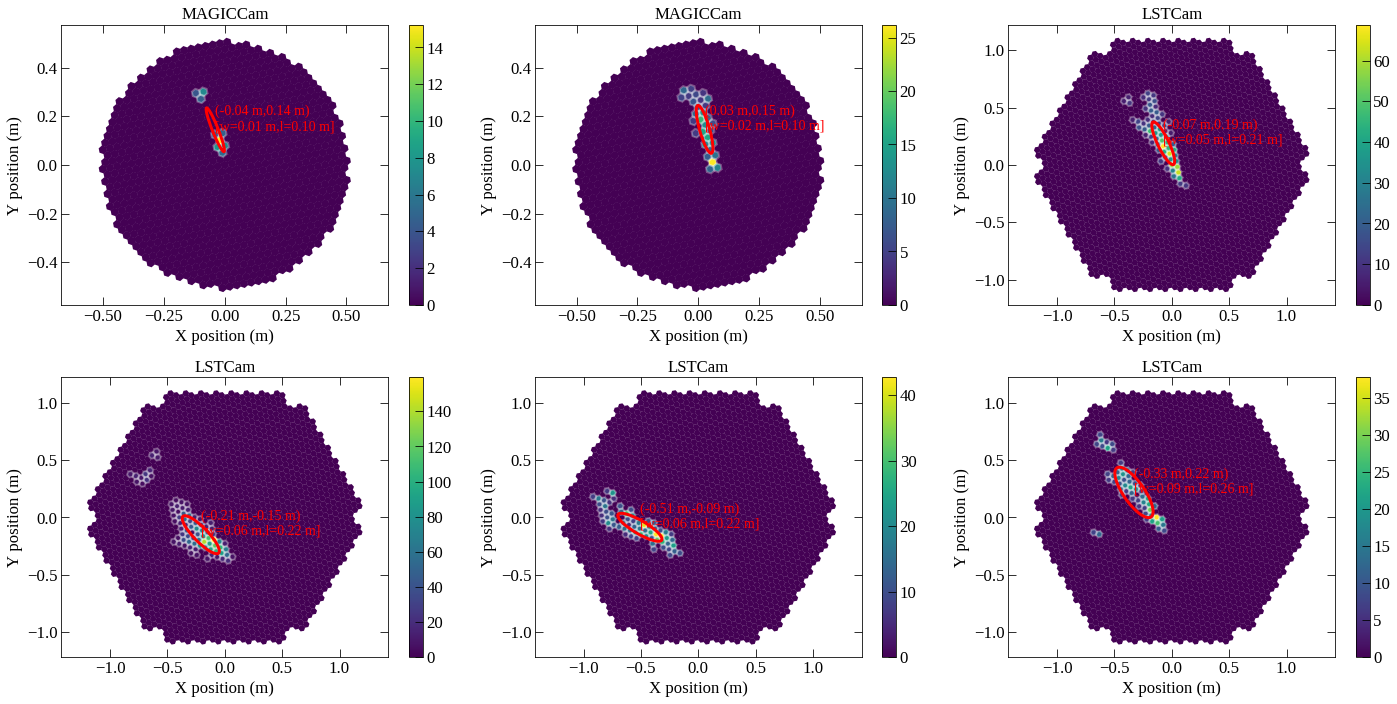

In [42]:
pyplot.figure(figsize=(20, 10))
pyplot.style.use('presentation')

for tel_id in tels_with_data:
    pyplot.subplot(2, 3, tel_id)
    
    event_image = event.dl1.tel[tel_id].image[1]
    
    if tel_id <= 2:
        # Image cleainig
        mask = tailcuts_clean(magic_camera, event_image, picture_thresh=6, boundary_thresh=4)
        event_image_cleaned = event_image.copy()
        event_image_cleaned[~mask] = 0
        
        # Hillas parameters
        hillas_params = hillas_parameters(magic_camera, event_image_cleaned)
        
        # Display the event
        disp = CameraDisplay(magic_camera, event_image_cleaned)
        
        # Overlay computed hillas parameters
        disp.overlay_moments(hillas_params, color='red', lw=3)
        disp.highlight_pixels(mask, color='white', alpha=0.3, linewidth=2)

    else:
        # Image cleainig
        mask = tailcuts_clean(lst_camera, event_image, picture_thresh=10, boundary_thresh=5)
        event_image_cleaned = event_image.copy()
        event_image_cleaned[~mask] = 0
        
        # Hillas parameters
        hillas_params = hillas_parameters(lst_camera, event_image_cleaned)
        
        # Display the event
        disp = CameraDisplay(lst_camera, event_image_cleaned)
        
        # Overlay computed hillas parameters
        disp.overlay_moments(hillas_params, color='red', lw=3)
        disp.highlight_pixels(mask, color='white', alpha=0.3, linewidth=2)
        
    disp.add_colorbar()
    
pyplot.tight_layout()

## 8. On our way to a common MAGIC+LST data processing

First create event metadata container to hold event / observation / telescope IDs and MC true values for the event energy and direction. We will need it to add this information to the event Hillas parameters when dumping the results to disk.

In [44]:
from ctapipe.core.container import Container, Field

class InfoContainer(Container):
    obs_id = Field(-1, "Observation ID")
    event_id = Field(-1, "Event ID")
    tel_id = Field(-1, "Telescope ID")
    true_energy = Field(-1, "MC event energy", unit=u.TeV)
    true_alt = Field(-1, "MC event altitude", unit=u.rad)
    true_az = Field(-1, "MC event azimuth", unit=u.rad)
    tel_alt = Field(-1, "MC telescope altitude", unit=u.rad)
    tel_az = Field(-1, "MC telescope azimuth", unit=u.rad)

Setting up the calibrator class.

In [45]:
config = traitlets.config.Config()
config['NeighbourPeakIntegrator']['window_width'] = 6
config['NeighbourPeakIntegrator']['window_shift'] = 2
config['CameraDL1Calibrator']['clip_amplitude'] = 8000

calibrator = CameraCalibrator(r1_product="HESSIOR1Calibrator", 
                              extractor_product="NeighbourPeakIntegrator", config=config)

Now let's loop over the events and perform:
 - image cleaning;
 - hillas parameter calculation;
 - time gradient calculation.
 
We'll also write the result to the HDF5 file that can be used for further processing.

In [46]:
# Event source
source = event_source(input_data_file, allowed_tels=[1,2,3,4,5,6], max_events=10)

# Opening the output file
with HDF5TableWriter(filename='hillas.hdf5', group_name='dl1', overwrite=True) as writer:
    # Looping over the events
    for event in source:
        tels_with_data = event.r1.tels_with_data

        # Calibrating an event
        calibrator.calibrate(event)

        # Looping over the triggered telescopes
        for tel_id in tels_with_data:
            # Obtained image
            event_image = event.dl1.tel[tel_id].image[1]
            # Peak pos map
            event_peakpos = event.dl1.tel[tel_id].peakpos[1]
            # Camera geometry
            camera = event.inst.subarray.tel[tel_id].camera

            # Cleaning the image
            mask = tailcuts_clean(camera, event_image, picture_thresh=6, boundary_thresh=4)
            event_image_cleaned = event_image.copy()
            event_image_cleaned[~mask] = 0
            event_peakpos_cleaned = event_peakpos.copy()
            event_peakpos_cleaned[~mask] = 0

            if event_image_cleaned.sum() > 0:
                # If event has survived the cleaning, computing the Hillas parameters
                hillas_params = hillas_parameters(camera, event_image_cleaned)
                timing_params = timing_parameters(camera, event_image_cleaned, event_peakpos_cleaned, hillas_params)

                # Preparing metadata
                event_info = InfoContainer(obs_id=event.dl0.obs_id, 
                                           event_id=event.dl0.event_id,
                                           tel_id=tel_id,
                                           true_energy=event.mc.energy,
                                           true_alt=event.mc.alt,
                                           true_az=event.mc.az,
                                           tel_alt=event.mc.tel[tel_id].altitude_raw * u.rad,
                                           tel_az=event.mc.tel[tel_id].azimuth_raw * u.rad)
            
                # Storing the result
                writer.write("hillas_params", (event_info, hillas_params, timing_params))

Let's read and check the resulting table.

In [47]:
dl1_data = pd.read_hdf("hillas.hdf5")
dl1_data.set_index(['obs_id', 'event_id', 'tel_id'], inplace=True)
dl1_data.sort_index(inplace=True)

dl1_data

intensity  intercept   kurtosis    length  \
obs_id event_id tel_id                                                
9      100      4         79.627232  11.541764   3.770654  0.326449   
       102      1         65.760828  14.162222   2.103441  0.022040   
                3        324.532105  10.305232  12.316970  0.164023   
                4        102.630468   7.972539   3.023870  0.378923   
                6        371.956785  10.150519  25.194744  0.180230   
       108      5         50.521787   7.833844   2.345751  0.041515   
       109      3        165.541044   9.110278   2.297372  0.048890   
                4         67.561078   8.674792   4.169072  0.266602   
                5        205.938649   9.600015   1.916570  0.075229   
                6        285.741673  10.195029  17.709926  0.121307   
       200      1         60.040611  15.031138   2.119164  0.096633   
                2        271.418865  17.452681   1.895527  0.102086   
                3       1528.523104  12.407828   3.455877  0.234045   
                4       2994.552592  12.062030   5.550295  0.242100   
                5       1053.484825  13.539575   2.357767  0.232843   
                6        807.128485  15.684119   2.054172  0.278166   
       201      6        169.368937   9.573846   2.025239  0.071359   
       202      1         18.328726  14.753427   1.832225  0.019155   
                2        159.151826  17.711722   2.249676  0.117128   
                3       1408.943575  13.520853   2.683097  0.255287   
                4       3928.202402  12.163397   3.753437  0.173122   
                5       1519.590586  12.860955   2.838359  0.220243   
                6        850.768635  13.871365   3.337144  0.286254   
       203      3        143.020126  10.789941   3.412964  0.681691   
                4         56.720539   8.293075   3.632818  0.522316   
       204      5        186.461934  10.768370  11.332765  0.371369   
       205      3       1018.817753  12.502812   2.377216  0.159938   
                4        168.891874  11.099447  11.186435  0.325476   
                6        308.881693  12.044360  18.078478  0.231947   

                               phi         psi         r  skewness      slope  \
obs_id event_id tel_id                                                          
9      100      4       112.261727   52.491111  0.827649 -1.652204 -24.617233   
       102      1        65.545089  149.151246  0.358962  0.059562  13.379711   
                3         9.574491  -71.954222  0.528665  3.119469   7.142964   
                4       -57.382712   10.085180  0.334580 -1.334637   1.380553   
                6        35.529004   77.921115  0.276058 -4.744214  -9.377707   
       108      5        56.432212   53.353727  1.114084 -0.448067 -13.144064   
       109      3        12.718465  -46.506550  0.878235  0.227454   3.204021   
                4       -14.676664   15.334893  0.657617 -1.769315  -2.221546   
                5        -9.265601  -86.443373  0.457061  0.332975   9.349306   
                6        18.437328  -58.253576  0.660358  3.734336   6.848181   
       200      1       124.252642  130.836000  0.149678  0.942767  39.155738   
                2        99.059630  125.034653  0.148463 -0.013335  29.355675   
                3       113.220666  118.822155  0.222269  0.647430  10.710422   
                4      -146.606801  131.802404  0.258594  1.362666   7.808332   
                5      -170.884783  149.242530  0.518006  0.418745  13.620559   
                6       145.036630  126.242947  0.437944  0.234660  14.121224   
       201      6       -67.077288  -72.060021  1.099401 -0.644877  14.791198   
       202      1        88.338524  122.106662  0.272762  0.063292  87.616731   
                2        66.873364  107.792424  0.267547  0.570723  31.217632   
                3        60.382106   95.187105  0.397872  0.554112  11.034466   
                4       -26.756713  -69.47

Higher level analysis starts here...